In [49]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from imblearn.over_sampling import SMOTE as smote
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek

from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [48]:
df = pd.read_csv('assignment-data/data_for_student_case.csv', dtype={'bin':str, 'amount':int})
df = df.drop(['txid','bookingdate'], axis='columns')
df = df.rename(index=str, columns={'issuercountrycode':'issuercountry', 
                                   'bin':'issuer_id', 
                                   'shoppercountrycode':'shoppercountry', 
                                   'shopperinteraction':'interaction', 
                                   'cardverificationcodesupplied':'verification', 
                                   'cvcresponsecode':'cvcresponse', 
                                   'creationdate':'creationdate_stamp', 
                                   'simple_journal':'label'})

# Skip data if:
df = df[df['label']!='Refused']
df = df[~df['issuer_id'].str.contains('na', case=False)]
df = df[~df['mail_id'].str.contains('na', case=False)]

# Create and format (new) columns
df['issuer_id'] = pd.to_numeric(df['issuer_id'])
df['creationdate'] = (pd.to_datetime(df['creationdate_stamp'])).dt.date
df['mail_id'] = pd.to_numeric(df['mail_id'].str.replace('email','')).astype(int)
df['ip_id'] = pd.to_numeric(df['ip_id'].str.replace('ip','')).astype(int)
df['card_id'] = pd.to_numeric(df['card_id'].str.replace('card','')).astype(int)
df['label'] = pd.to_numeric(df['label'].apply(lambda x: '1' if x == 'Chargeback' else '0'))
df['subscription'] = pd.to_numeric(df['interaction'].apply(lambda x: '1' if x == 'ContAuth' else '0'))
df['verification'] = pd.to_numeric(df['verification'].apply(lambda x: '1' if x else '0'))

countries = pd.concat([df[['issuercountry','amount']].rename(columns = {"issuercountry": "country"}), df[['shoppercountry','amount']].rename(columns = {"shoppercountry": "country"})])
countries = countries.groupby('country')['amount'].agg(['count']).sort_values('count').reset_index()
countries = countries['country'].tolist()
countries_type = pd.api.types.CategoricalDtype(categories=countries)
df['shoppercountry_id'] = df['shoppercountry'].astype(countries_type).cat.codes
df['issuercountry_id'] = df['issuercountry'].astype(countries_type).cat.codes

txvariant = df.groupby('txvariantcode')['amount'].agg(['count']).sort_values('count').reset_index()
txvariant = txvariant['txvariantcode'].tolist()
txvariant_type = pd.api.types.CategoricalDtype(categories=txvariant)
df['txvariant_id'] = df['txvariantcode'].astype(txvariant_type).cat.codes

accounttype = df.groupby('accountcode')['amount'].agg(['count']).sort_values('count').reset_index()
accounttype = accounttype['accountcode'].tolist()
accounttype_type = pd.api.types.CategoricalDtype(categories=accounttype)
df['account_id'] = df['accountcode'].astype(accounttype_type).cat.codes

currency = df.groupby('currencycode')['amount'].agg(['count']).sort_values('count').reset_index()
currency = currency['currencycode'].tolist()
currency_type = pd.api.types.CategoricalDtype(categories=currency)
df['currency_id'] = df['currencycode'].astype(currency_type).cat.codes


converter = {
    'AUD': 0.702495,
    'GBP': 1.305505,
    'MXN': 0.05274,
    'NZD': 0.6632,
    'SEK': 0.104965
}

def convert_to_usd(args): 
    amount, currency = args
    return converter[currency] * amount / 100

df['usd_amount'] = df[['amount', 'currencycode']].apply(convert_to_usd, axis=1)

avg_expense = df.groupby('card_id')['usd_amount'].mean().reset_index().rename(columns={'usd_amount': 'avg_amount'})
df = pd.merge(df, avg_expense, on='card_id')
df['dif_avg_amount'] = df['usd_amount'] - df['avg_amount']

print(df.groupby('cvc')['amount'].agg('count'))

print(df.dtypes)

KeyError: 'cvc'

In [3]:
fraud = df[df['label']==1]
benign = df[df['label']==0]

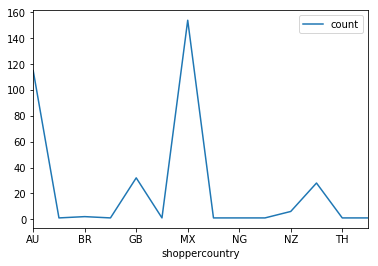

In [4]:
ip = fraud.groupby('shoppercountry')['amount'].agg(['count'])
# print(ip)
# for e in ip:
#     print(e)
ip.plot()

# print(fraud['usd_amount'].describe())
# print(benign['usd_amount'].describe())
# fraud['usd_amount'].plot()


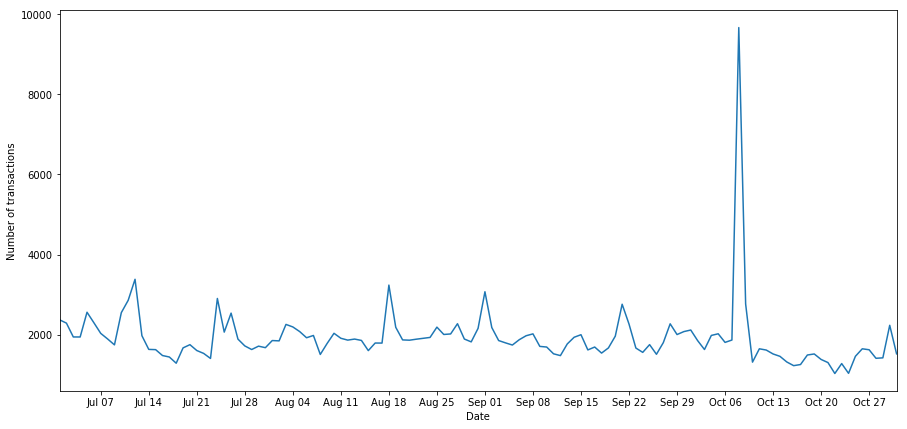

In [5]:
t_day = df.groupby('creationdate')['amount'].agg(['count'])
t_ip = df.groupby('ip_id')['amount'].agg(['count'])

plt.figure(1, figsize=(15,7))
fig = plt.gcf()
ax = plt.gca()

t_day.plot(ax=ax)
ax.set(xlabel="Date", ylabel="Number of transactions")
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.get_legend().remove()

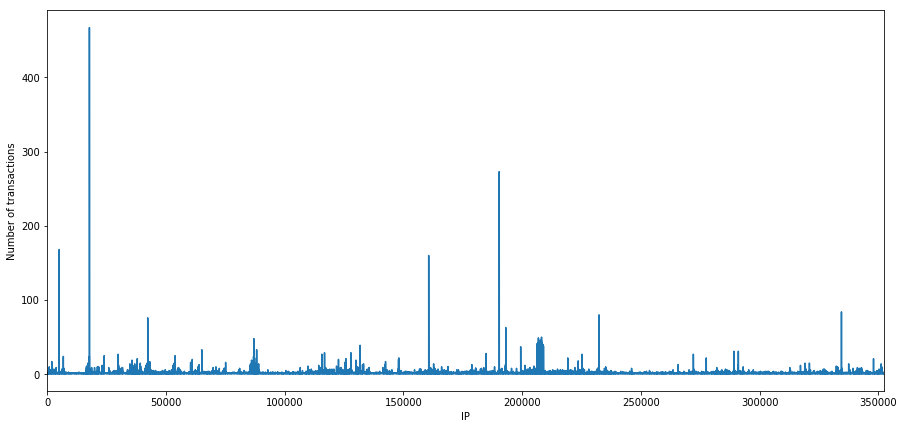

In [6]:
t_ip = df.groupby('ip_id')['amount'].agg(['count'])
t_ip = t_ip.sort_index()

plt.figure(2, figsize=(15,7))
fig = plt.gcf()
ax = plt.gca()

t_ip.plot(ax=ax)
ax.set(xlabel="IP", ylabel="Number of transactions")
ax.get_legend().remove()

In [7]:
c = fraud.groupby('issuercountry')['amount'].agg(['count'])
d = df.groupby('issuercountry')['amount'].agg(['count']).sort_values(['count'])

histogram_intersection = lambda a, b: np.minimum(a, b).sum().round(decimals=2)

df.corr(method='pearson')

,issuer_id,amount,label,verification,cvcresponse,mail_id,ip_id,card_id,subscription,shoppercountry_id,issuercountry_id,txvariant_id,account_id,currency_id,usd_amount,avg_amount,dif_avg_amount
issuer_id,1.000000e+00,0.156597,0.013784,-0.006347,-0.073648,-0.000151,-0.031797,-2.471974e-04,0.006379,-0.016507,-2.040679e-02,-1.510489e-01,-0.200232,-0.161260,0.049572,5.376692e-02,-2.190128e-18
amount,1.565968e-01,1.000000,0.078817,0.029003,-0.225500,-0.013983,-0.110045,-1.291288e-03,-0.028957,-0.069786,-1.492941e-01,-1.880990e-01,-0.717575,-0.606371,0.278859,2.618922e-01,9.658189e-02
label,1.378448e-02,0.078817,1.000000,-0.009143,-0.067436,-0.002098,-0.031991,8.436962e-04,0.009156,-0.007228,-2.618135e-02,-3.786329e-02,-0.069959,-0.059979,0.037128,3.920063e-02,2.546279e-03
verification,-6.346911e-03,0.029003,-0.009143,1.000000,0.355075,-0.012821,-0.005367,9.585296e-03,-0.999405,0.009017,-7.433572e-03,1.446133e-02,-0.055205,-0.051322,-0.034333,-4.456453e-02,1.744161e-02
cvcresponse,-7.364809e-02,-0.225500,-0.067436,0.355075,1.000000,0.004335,0.431935,2.779681e-03,-0.354857,0.055561,1.202886e-01,2.354999e-01,0.538216,0.587358,0.008297,6.136172e-03,6.817063e-03
mail_id,-1.514865e-04,-0.013983,-0.002098,-0.012821,0.004335,1.000000,0.005897,1.103704e-03,0.012857,0.001360,4.817134e-03,-3.109509e-03,0.018303,0.015468,-0.002310,-3.221386e-03,1.704621e-03
ip_id,-3.179686e-02,-0.110045,-0.031991,-0.005367,0.431935,0.005897,1.000000,2.489905e-03,0.005320,0.079552,1.004573e-01,1.325277e-01,0.277244,0.306943,-0.006098,-6.755396e-03,3.360720e-04
card_id,-2.471974e-04,-0.001291,0.000844,0.009585,0.002780,0.001104,0.002490,1.000000e+00,-0.009543,-0.003285,1.493594e-04,-3.987070e-03,-0.000958,-0.001300,-0.001339,-1.452217e-03,1.228593e-18
subscription,6.378658e-03,-0.028957,0.009156,-0.999405,-0.354857,0.012857,0.005320,-9.542702e-03,1.000000,-0.009055,7.396755e-03,-1.443495e-02,0.055137,0.051253,0.034370,4.460876e-02,-1.745139e-02
shoppercountry_id,-1.650689e-02,-0.069786,-0.007228,0.009017,0.055561,0.001360,0.079552,-3.285426e-03,-0.009055,1.000000,2.297289e-01,5.885252e-02,0.091254,0.102785,-0.024437,-2.713021e-02,1.488853e-03


In [8]:
# If we want to use a all-combiner. This should yield less false positives. 
# from brew.base import Ensemble
# from brew.base import EnsembleClassifier
# from brew.combination.combiner import Combiner

# # create your Ensemble
# clfs = your_list_of_classifiers # [clf1, clf2]
# ens = Ensemble(classifiers = clfs)

# # create your Combiner
# # the rules can be 'majority_vote', 'max', 'min', 'mean' or 'median'
# comb = Combiner(rule='mean')

# # now create your ensemble classifier
# ensemble_clf = EnsembleClassifier(ensemble=ens, combiner=comb)
# ensemble_clf.predict(X)

In [9]:
# preprocessed = df.drop(['label', 'creationdate_stamp', 'creationdate', 'accountcode', 
#                         'currencycode', 'shoppercountry', 'interaction', 
#                         'issuercountry', 'txvariantcode'], axis=1)

# preprocessed = df[['amount', 'subscription', 'currency_id']][0:4000]
# data_numeric = df[['issuer_id' 'amount' 'label' 'verification' 'cvcresponse' 'mail_id' 'ip_id' 'card_id' 'subscription' 'shoppercountry_id' 'issuercountry_id' 'txvariant_id' 'account_id' 'currency_id']

# clf = svm.SVC(kernel='linear', C=1)
# scores = cross_val_score(clf, preprocessed, df['label'][0:4000], cv=3)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [30]:
def compare_sampling(classifier, classifier_name, sampling_name, train_ft, train_ft_smote, test_ft, train_lbl, train_lbl_smote, test_lbl):
    fig = plt.figure()
    
    plot_line_compare_sampling(classifier, classifier_name, 'normal', train_ft, test_ft, train_lbl, test_lbl)
    plot_line_compare_sampling(classifier, classifier_name, sampling_name, train_ft_smote, test_ft, train_lbl_smote, test_lbl)
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparise %s for a %s with ROC curves' %(sampling_name, classifier_name))
    plt.legend(loc="lower right")
    plt.show()
    
def plot_line_compare_sampling(classifier, classifier_name, line_label, train_ft, test_ft, train_lbl, test_lbl):
    classifier.fit(train_ft, train_lbl)
    
    predict_lbl = classifier.predict_proba(test_ft)
    predict_lbl = predict_lbl[:, 1]
    
    predict_decision_lbl = classifier.predict(test_ft)
    print(line_label+':')
    print(confusion_matrix(test_lbl, predict_decision_lbl))
    
    fp_rate, tp_rate, thresholds = roc_curve(test_lbl, predict_lbl, pos_label =True)
    area = auc(fp_rate, tp_rate)
    plt.plot(fp_rate, tp_rate, label=('ROC %s (area = %0.2f)') %(line_label, area))
    
    if classifier_name == "Decision Tree Classifier":
        export_graphviz(classifier, out_file='tree_%s.dot' %(line_label))   
    

normal:
[[47267     6]
 [   67     0]]
SMOTE:
[[40317  6956]
 [   15    52]]


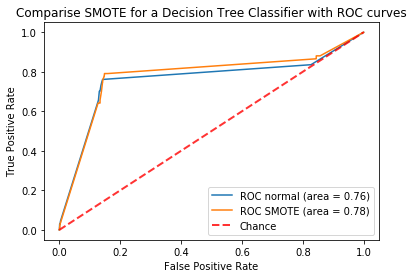

normal:
[[47267     6]
 [   66     1]]
SMOTE:
[[40848  6425]
 [   20    47]]


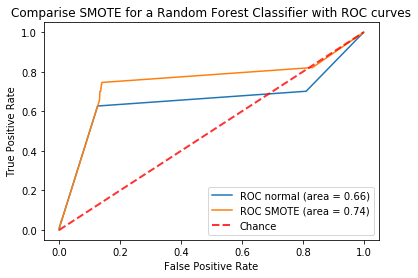

normal:
[[45965  1308]
 [   62     5]]
SMOTE:
[[38688  8585]
 [    9    58]]


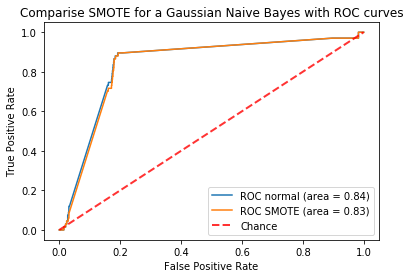

normal:
[[47271     2]
 [   67     0]]
SMOTE:
[[39586  7687]
 [   14    53]]


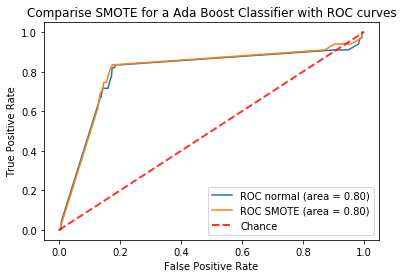

In [45]:
# data_ft = df[['usd_amount', 'dif_avg_amount', 'subscription', 'verification', 'cvcresponse']].values
data_ft = df[['dif_avg_amount', 'cvcresponse', 'verification', 'cvc']].values
data_lbl = df[['label']].values.ravel()

train_ft, test_ft, train_lbl, test_lbl = train_test_split(data_ft,data_lbl,test_size=0.2)

sm = smote(sampling_strategy = 'minority')

train_ft_smote, train_lbl_smote = sm.fit_sample(train_ft,train_lbl)

compare_sampling(DecisionTreeClassifier(max_depth = 10), "Decision Tree Classifier", 'SMOTE', train_ft, train_ft_smote, test_ft, train_lbl, train_lbl_smote, test_lbl)
compare_sampling(RandomForestClassifier(n_estimators=10), "Random Forest Classifier", 'SMOTE', train_ft, train_ft_smote, test_ft, train_lbl, train_lbl_smote, test_lbl)
compare_sampling(GaussianNB(), "Gaussian Naive Bayes", 'SMOTE', train_ft, train_ft_smote, test_ft, train_lbl, train_lbl_smote, test_lbl)
compare_sampling(AdaBoostClassifier(), "Ada Boost Classifier", 'SMOTE', train_ft, train_ft_smote, test_ft, train_lbl, train_lbl_smote, test_lbl)


normal:
[[47259    11]
 [   68     2]]
Random Under Sampler:
[[38246  9024]
 [   12    58]]


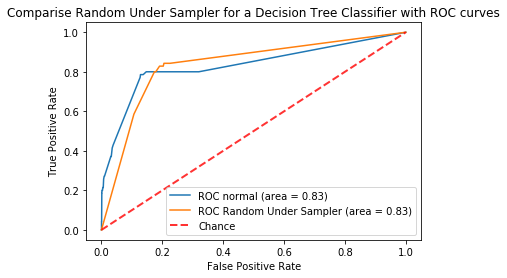

normal:
[[47251    19]
 [   65     5]]
Random Under Sampler:
[[38595  8675]
 [   12    58]]


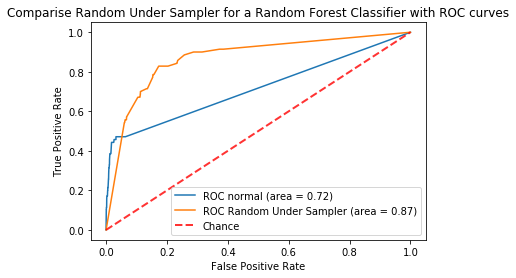

normal:
[[45802  1468]
 [   60    10]]
Random Under Sampler:
[[43287  3983]
 [   36    34]]


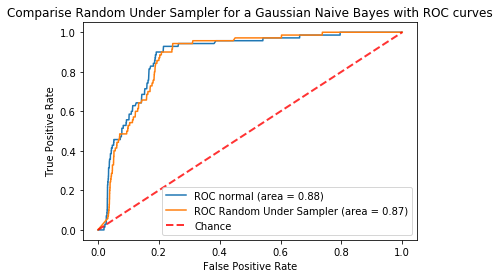

normal:
[[47263     7]
 [   69     1]]
Random Under Sampler:
[[37858  9412]
 [    7    63]]


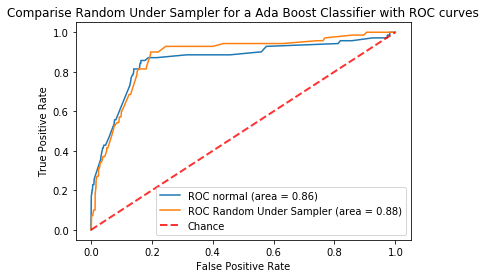

In [41]:
data_ft = df[['usd_amount', 'dif_avg_amount', 'subscription', 'verification', 'cvcresponse']].values
data_lbl = df[['label']].values.ravel()

train_ft, test_ft, train_lbl, test_lbl = train_test_split(data_ft,data_lbl,test_size=0.2)

rus = RandomUnderSampler()

train_ft_rus, train_lbl_rus = rus.fit_sample(train_ft,train_lbl)

compare_sampling(DecisionTreeClassifier(), "Decision Tree Classifier", 'Random Under Sampler', train_ft, train_ft_rus, test_ft, train_lbl, train_lbl_rus, test_lbl)
compare_sampling(RandomForestClassifier(n_estimators=10), "Random Forest Classifier", 'Random Under Sampler', train_ft, train_ft_rus, test_ft, train_lbl, train_lbl_rus, test_lbl)
compare_sampling(GaussianNB(), "Gaussian Naive Bayes", 'Random Under Sampler', train_ft, train_ft_rus, test_ft, train_lbl, train_lbl_rus, test_lbl)
compare_sampling(AdaBoostClassifier(), "Ada Boost Classifier", 'Random Under Sampler', train_ft, train_ft_rus, test_ft, train_lbl, train_lbl_rus, test_lbl)


normal:
[[47252    23]
 [   62     3]]
TomekLinks:
[[47243    32]
 [   62     3]]


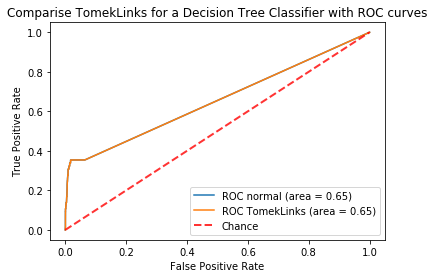

normal:
[[47265    10]
 [   62     3]]
TomekLinks:
[[47268     7]
 [   62     3]]


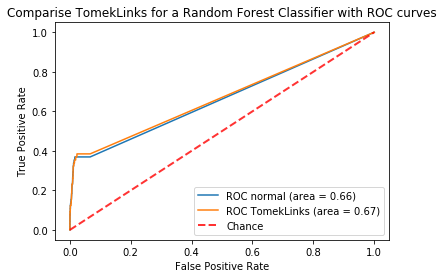

normal:
[[45853  1422]
 [   54    11]]
TomekLinks:
[[45852  1423]
 [   54    11]]


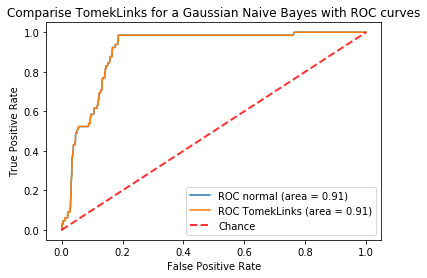

normal:
[[47274     1]
 [   65     0]]
TomekLinks:
[[47274     1]
 [   65     0]]


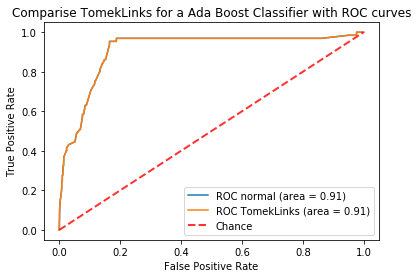

In [16]:
data_ft = df[['usd_amount', 'dif_avg_amount', 'subscription', 'verification', 'cvcresponse']].values
data_lbl = df[['label']].values.ravel()

train_ft, test_ft, train_lbl, test_lbl = train_test_split(data_ft,data_lbl,test_size=0.2)

tl = TomekLinks(ratio='majority')

train_ft_tl, train_lbl_tl = tl.fit_sample(train_ft,train_lbl)

compare_sampling(DecisionTreeClassifier(), "Decision Tree Classifier", 'TomekLinks', train_ft, train_ft_tl, test_ft, train_lbl, train_lbl_tl, test_lbl)
compare_sampling(RandomForestClassifier(n_estimators=10), "Random Forest Classifier", 'TomekLinks', train_ft, train_ft_tl, test_ft, train_lbl, train_lbl_tl, test_lbl)
compare_sampling(GaussianNB(), "Gaussian Naive Bayes", 'TomekLinks', train_ft, train_ft_tl, test_ft, train_lbl, train_lbl_tl, test_lbl)
compare_sampling(AdaBoostClassifier(), "Ada Boost Classifier", 'TomekLinks', train_ft, train_ft_tl, test_ft, train_lbl, train_lbl_tl, test_lbl)


normal:
[[47232    31]
 [   69     8]]
SMOTE + Tomek links:
[[46274   989]
 [   46    31]]


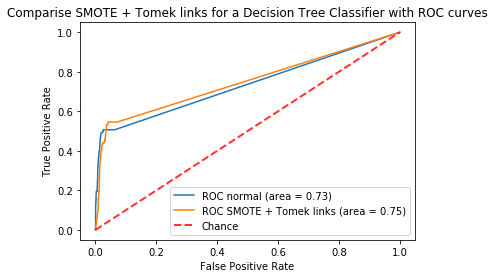

normal:
[[47251    12]
 [   72     5]]
SMOTE + Tomek links:
[[46241  1022]
 [   46    31]]


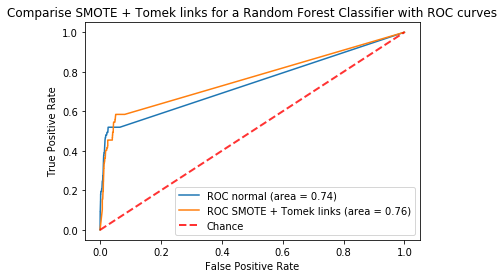

normal:
[[45778  1485]
 [   69     8]]
SMOTE + Tomek links:
[[38487  8776]
 [    7    70]]


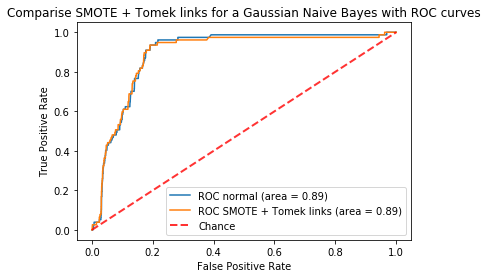

normal:
[[47263     0]
 [   77     0]]
SMOTE + Tomek links:
[[39941  7322]
 [   10    67]]


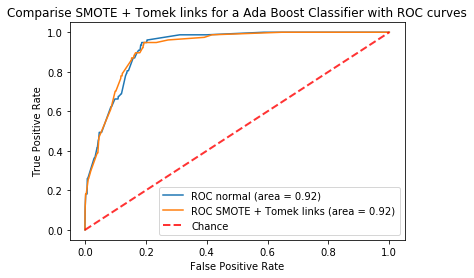

In [19]:
data_ft = df[['usd_amount', 'dif_avg_amount', 'subscription', 'verification', 'cvcresponse']].values
data_lbl = df[['label']].values.ravel()

train_ft, test_ft, train_lbl, test_lbl = train_test_split(data_ft,data_lbl,test_size=0.2)

smt = SMOTETomek(ratio='auto')

train_ft_smt, train_lbl_smt = smt.fit_sample(train_ft,train_lbl)

compare_sampling(DecisionTreeClassifier(), "Decision Tree Classifier", 'SMOTE + Tomek links', train_ft, train_ft_smt, test_ft, train_lbl, train_lbl_smt, test_lbl)
compare_sampling(RandomForestClassifier(n_estimators=10), "Random Forest Classifier", 'SMOTE + Tomek links', train_ft, train_ft_smt, test_ft, train_lbl, train_lbl_smt, test_lbl)
compare_sampling(GaussianNB(), "Gaussian Naive Bayes", 'SMOTE + Tomek links', train_ft, train_ft_smt, test_ft, train_lbl, train_lbl_smt, test_lbl)
compare_sampling(AdaBoostClassifier(), "Ada Boost Classifier", 'SMOTE + Tomek links', train_ft, train_ft_smt, test_ft, train_lbl, train_lbl_smt, test_lbl)
